In [1]:
import natsort
from natsort import natsorted
import os
import re
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
from skimage.io import imread, imshow, imread_collection, concatenate_images
from keras import optimizers
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.preprocessing import image
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import sklearn.neighbors
import time
import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
import random
from sklearn.model_selection import train_test_split

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
# caching with sane defaults
from cachier import cachier
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')
# define the seed to make sure that we are consistently getting the same results
seed = 42
np.random.seed = seed

Using TensorFlow backend.
/home-mscluster/smgidi/anaconda3/envs/mask_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home-mscluster/smgidi/anaconda3/envs/mask_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home-mscluster/smgidi/anaconda3/envs/mask_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

## 1. Image Pre-processing

In [2]:
############################## Stuff for loading and rescaling the puzzle pieces nicely ################################
def get_filenames():
    size= (768, 1024)
    data_path = list(zip(
        natsorted(glob(f'./datasets/puzzle_corners_{size[1]}x{size[0]}/images-{size[1]}x{size[0]}/*.png')),
        natsorted(glob(f'./datasets/puzzle_corners_{size[1]}x{size[0]}/masks-{size[1]}x{size[0]}/*.png')),
    ))

    return data_path, size

def data_loader():
    
    dataset_path, size = get_filenames()
    DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(dataset_path, 'Loading Images')])
    DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(dataset_path, 'Loading Masks')])

    assert DATA_IMGS.shape == (48, size[0], size[1], 3)
    assert DATA_MSKS.shape == (48, size[0], size[1])

    images = DATA_IMGS.copy()
    masks = DATA_MSKS.copy()
    return images, masks
all_images, all_masks = data_loader()

Loading Masks: 100%|██████████| 48/48 [00:00<00:00, 339.93it/s]


## 1.1 Resize Images and Correspondimg Masks

In [3]:
def resize_images(images, masks, scale):

    orig_images = images.copy()
    orig_masks = masks.copy()
    images = [cv2.resize(img, None, fx=scale, fy=scale) for img in tqdm(images, 'Resizing Images')]
    # this is a numpy array with shape (height, width)
    masks = [cv2.resize(img, None, fx=scale, fy=scale) for img in tqdm(masks, 'Resizing Masks')]

    masks = np.expand_dims(masks, axis=3)  # this is a numpy array with shape (1, height, width)
    print('\n', orig_images[0].shape, '=>', images[0].shape) 
    print('\n', orig_masks[0].shape, '=>', masks[0].shape)  
    
    return images, masks

resized_images, resized_masks = resize_images(all_images,all_masks, scale=0.25)

Resizing Masks: 100%|██████████| 48/48 [00:00<00:00, 11043.09it/s]


 (768, 1024, 3) => (192, 256, 3)

 (768, 1024) => (192, 256, 1)


## 1.3 Display Images and Masks

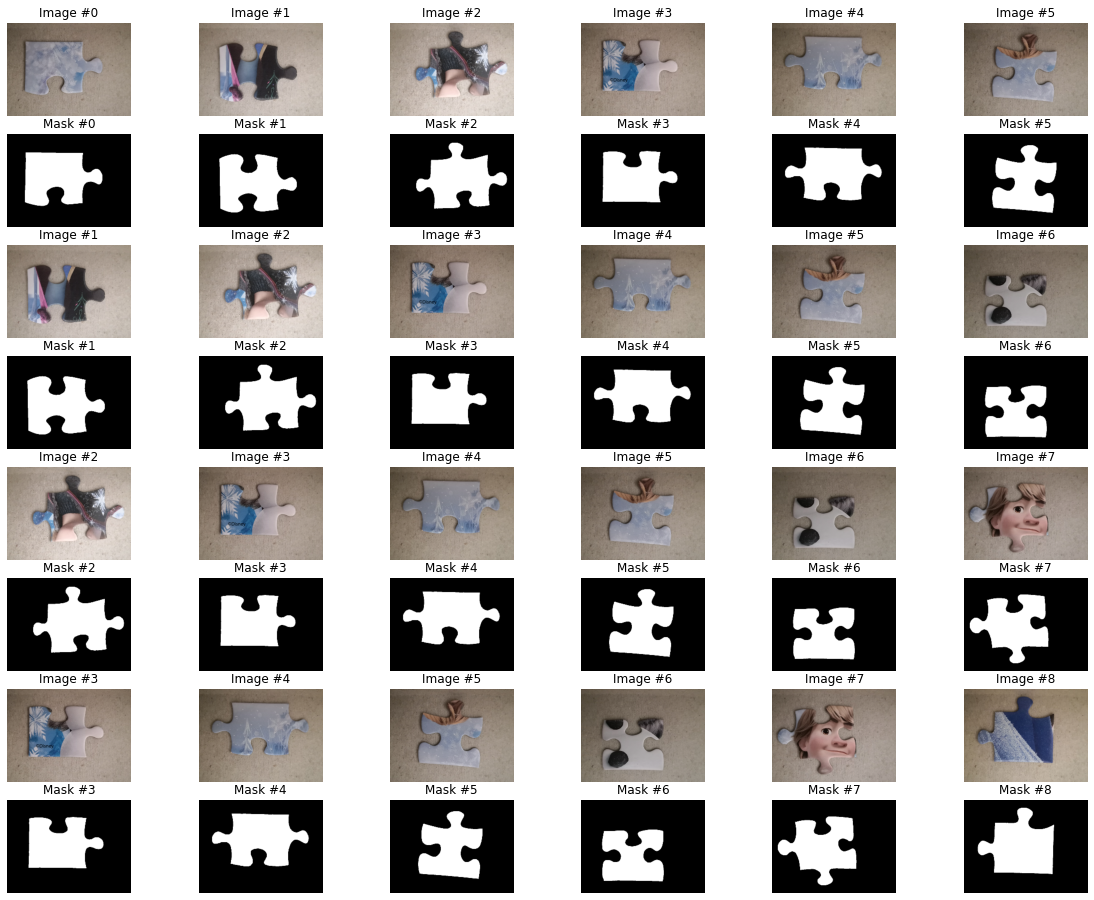

In [4]:
def visualize_images(images, masks):

    plt.figure(figsize=(20,16))
    x, y = 6,4

    for i in range(y):  
        for j in range(x):
            # images 
            plt.subplot(y*2, x, i*2*x+j+1)
            pos =  i+j
            plt.imshow(images[pos])
            plt.title('Image #{}'.format(pos))
            plt.axis('off')
            plt.subplot(y*2, x, (i*2+1)*x+j+1)
            
            # display corresponding masks
            plt.imshow(np.squeeze(masks[pos]), cmap="gray")
            plt.title('Mask #{}'.format(pos))
            plt.axis('off')
    plt.show()

visualize_images(resized_images, resized_masks)

### 1.4 Split Images and Masks

In [5]:
# split the training(85%) and testing(15%) dataset
train_val_imgs, test_images, train_val_msks,  test_masks = train_test_split(resized_images, resized_masks, test_size = 0.14)
train_imgs, val_imgs, train_msks, val_msks = train_test_split(train_val_imgs,train_val_msks, test_size=0.15)

# training images 70%
train_imgs = np.array(train_imgs)
train_msks= np.array(train_msks)

# validation images 15%
val_imgs = np.array(val_imgs)
val_msks = np.array(val_msks)

# testing images 15%
test_imgs = np.array(test_images)
test_msks = np.array(test_masks)

print("Training images: ",len(train_imgs))
print("Training masks: ",len(train_msks))

print("Validation images: ",len(val_imgs))
print("Validation masks: ",len(val_msks))

print("Testing images: ", len(test_imgs))
print("Testing masks: ", len(test_msks))

Training images:  34
Training masks:  34
Validation images:  7
Validation masks:  7
Testing images:  7
Testing masks:  7


### 1.5 Apply Data Augmentation

In [6]:
def data_augmentation(train_images, train_masks):
    train_imgs = np.append(train_images, [ np.fliplr(img) for img in train_images], axis=0)
    train_msks = np.append(train_masks, [ np.fliplr(msk) for msk in train_masks], axis=0)
    train_imgs = img_as_float32(train_imgs)
    train_msks = img_as_float32(train_msks)

    return train_imgs, train_msks
train_imgs_aug, train_msks_aug = data_augmentation(train_imgs, train_msks)
print("Augmented training images ",len(train_imgs_aug))
print("Augmented training masks ",len(train_msks_aug))

Augmented training images  68
Augmented training masks  68


## 2. Evaluation Metrics

In [7]:
def get_iou(A,B):
    
    t = A>0
    p = B>0
    smooth = 1e-10
    union = np.logical_or(t, p)
    intersection = np.logical_and(A, B)
    iou = (np.sum(intersection) + smooth)/ (np.sum(union) + smooth)
    return iou

def iou_metric(mask, pred):
    metric = [mask, pred>0.5]
    return tf.py_func(get_iou, metric, tf.float64)

## 3. U-Net Implementation  

In [8]:
img_dimensions = (192, 256, 3)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3)):
    "Add 2 conv layer"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(input_tensor)

    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(x)
    return x

def unet_implementation(img_dimensions):
    
    vgg = VGG16(weights='imagenet',include_top=False, input_shape=img_dimensions)
    vgg.layers.pop()
    vgg.trainable=False
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv3').output)
    u1 = concatenate([u1,vgg.get_layer('block4_conv3').output])
    u1 = Dropout(0.1)(u1)
    c1 = conv2d_block(u1, 512)

    u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
    u2 = concatenate([u2,vgg.get_layer('block3_conv3').output])
    u2 = Dropout(0.1)(u2)
    c2 = conv2d_block(u2, 256)

    u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
    u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
    u3 = Dropout(0.1)(u3)
    c3 = conv2d_block(u3, 128)

    u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
    u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
    u4 = Dropout(0.1)(u4)
    c4 = conv2d_block(u4, 64)

    output = Conv2D(1, (1, 1), activation='sigmoid')(c4)
    
    unet = Model(vgg.input, output)
    unet_aug = Model(vgg.input, output)
    
    #compile the 
    unet.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'binary_crossentropy', metrics=['accuracy',iou_metric])
    unet_aug.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'binary_crossentropy', metrics=['accuracy',iou_metric])
    
    return unet, unet_aug

In [9]:
# initialize our callbacks

# make model weights for augmentation and no augmentation.
model_weights = "weights/model_best_checkpoint.h5"
model_weights_aug = "weights/aug_model_best_checkpoint.h5"
kf_model_weights = "weights/kfold_model_best_checkpoint.h5"
kf_model_weights_aug = "weights/kfold_aug_model_best_checkpoint.h5"

unet, unet_aug = unet_implementation(img_dimensions)

def model_checkpoints(weights):
    model_checkpoint  = ModelCheckpoint(weights, save_best_only=True, 
                                        monitor='val_loss', mode='min', verbose=1)
    return model_checkpoint

# (augment and no augment checkpoints)
model_checkpoint = model_checkpoints(model_weights)
aug_model_checkpoint = model_checkpoints(model_weights_aug)
kfold_model_checkpoint = model_checkpoints(kf_model_weights)
kfold_aug_model_checkpoint = model_checkpoints(kf_model_weights_aug)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')
callback_list = [early_stopping, model_checkpoint]

## 4. Fit the model without data augmentation  

In [10]:
start = time.time()
batch_size = 6
num_epochs = 50
results = unet.fit(train_imgs, train_msks,batch_size=batch_size, epochs=num_epochs, 
                   validation_data=(val_imgs,val_msks), callbacks=callback_list)
print("Elapsed time", round(time.time() - start,2), "seconds")

Train on 34 samples, validate on 7 samples
Epoch 1/50
34/34 [==============================] - 44s 1s/step - loss: 1.2769 - acc: 0.6870 - iou_metric: 0.2001 - val_loss: 0.4979 - val_acc: 0.7819 - val_iou_metric: 0.1303

Epoch 00001: val_loss improved from inf to 0.49786, saving model to weights/model_best_checkpoint.h5
Epoch 2/50
34/34 [==============================] - 43s 1s/step - loss: 0.3541 - acc: 0.8559 - iou_metric: 0.5046 - val_loss: 0.3147 - val_acc: 0.8671 - val_iou_metric: 0.4984

Epoch 00002: val_loss improved from 0.49786 to 0.31466, saving model to weights/model_best_checkpoint.h5
Epoch 3/50
34/34 [==============================] - 43s 1s/step - loss: 0.2077 - acc: 0.9179 - iou_metric: 0.7228 - val_loss: 0.2423 - val_acc: 0.9040 - val_iou_metric: 0.6357

Epoch 00003: val_loss improved from 0.31466 to 0.24227, saving model to weights/model_best_checkpoint.h5
Epoch 4/50
34/34 [==============================] - 43s 1s/step - loss: 0.1374 - acc: 0.9427 - iou_metric: 0.8015 -

## 5. Display the results (Without augmentation)

### 5.1 Display the model loss

In [11]:
def display_model_loss(num_epochs, history, title = None):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(num_epochs)

    plt.figure()
    plt.plot(epochs, loss, 'r',color = "red", label='Training loss')
    plt.plot(epochs, val_loss, 'r',color = "green", label='Validation loss')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

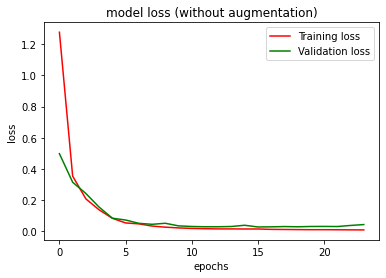

In [13]:
display_model_loss(24, results, "model loss (without augmentation)")   

### 5.2 Display model accuracy loss

In [14]:
def display_model_accuracy(num_epochs, history,title = None):
    
    loss = history.history['acc']
    val_loss = history.history['val_acc']

    epochs = range(num_epochs)

    plt.figure()
    plt.plot(epochs, loss, 'r',color = "red", label='Train Accuracy')
    plt.plot(epochs, val_loss, 'r',color = "green", label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('accuracy value')
    plt.legend()
    plt.show()


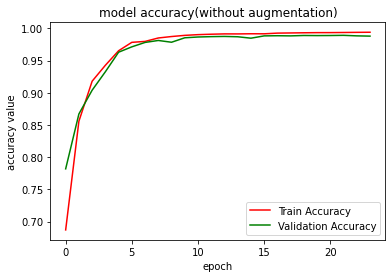

In [15]:
display_model_accuracy(24,results,"model accuracy(without augmentation)")   

### 5.3 Display IoU metrics loss 

In [16]:
def display_model_iou(num_epochs, history,title = None):
    
    loss = history.history['iou_metric']
    val_loss = history.history['val_iou_metric']

    epochs = range(num_epochs)

    plt.figure()
    plt.plot(epochs, loss, 'r',color = "red", label='train IoU metric')
    plt.plot(epochs, val_loss, 'r',color = "green", label='val IoU metric')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('IoU metric')
    plt.legend()
    plt.show()

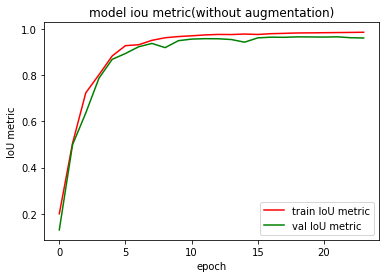

In [17]:
display_model_iou(24,results,"model iou metric(without augmentation)")

### 5.4 Prepare dataset for prediction

In [18]:
def get_model_weights(weights):
    model = load_model(weights, custom_objects={'iou_metric': iou_metric})
    return model

In [19]:
no_aug_model = get_model_weights(model_weights)

In [20]:
def do_predictions(train_imgs, val_imgs, model,test_imgs):
        
    # do prediction on 70% of the dataset
    preds_train = model.predict(train_imgs, verbose=1)
    
    # the last 15% used as validation
    preds_val = model.predict(val_imgs, verbose=1)

    # prediction on 15% of the test dataset which was not used during training
    preds_test = model.predict(test_imgs, verbose=1)

    # threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    return preds_val_t, preds_test_t

In [21]:
preds_val, preds_test = do_predictions(train_imgs,val_imgs,no_aug_model, test_imgs)

7/7 [==============================] - 3s 464ms/step


### 5.5 Evaluate the model on Testing dataset

In [22]:
# Plotting the original image, ground truth and predicted 
def display_prediction(orig_imgs, mask_imgs, pred_type):
    
    for i in range(len(orig_imgs)):
        plt.figure(figsize=(9,9))
        # display original image
        plt.subplot(131)
        imshow(orig_imgs[i])
        plt.axis("off")
        plt.title("Test image")


        # display mask
        plt.subplot(132)
        imshow(np.squeeze(mask_imgs[i]))
        plt.axis("off")
        plt.title("Test ground truth")

        # display segmentated output
        plt.subplot(133)
        imshow(np.squeeze(pred_type[i] > 0.5))
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
        print("IoU value:",round(get_iou(mask_imgs[i], pred_type[i]),2))

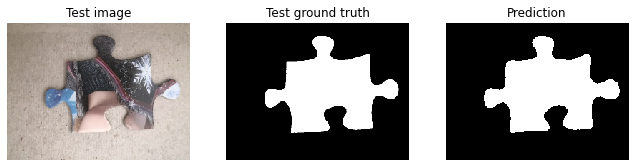

IoU value: 0.96


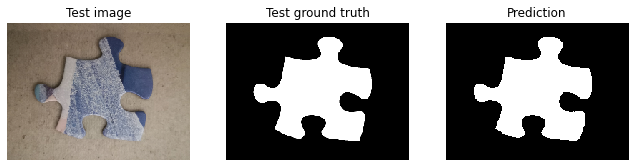

IoU value: 0.98


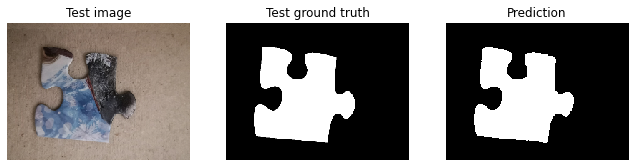

IoU value: 0.97


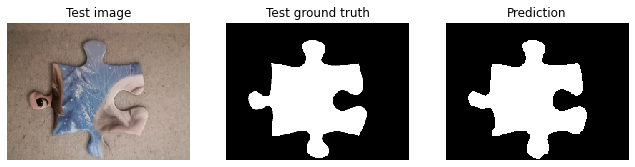

IoU value: 0.96


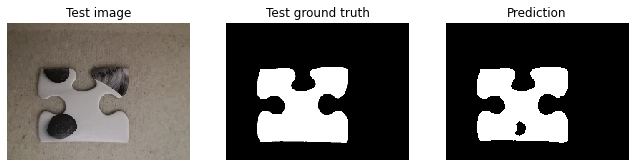

IoU value: 0.94


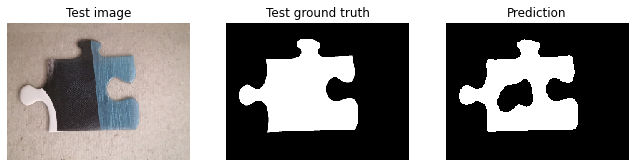

IoU value: 0.86


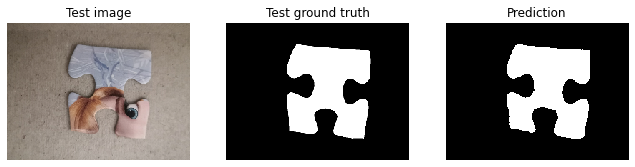

IoU value: 0.96


In [23]:
#display predictions
display_prediction(test_imgs,test_msks,preds_test)

### 5.6 Compute Intersection over Union(IoU)
Calculate the (IoU) over the entire testing dataset

In [24]:
def compute_iou(masks, preds):
    iou = []
    count = 0
    for i in range(len(masks)):
        iou.append(get_iou(masks[i], preds[i]))
        count =  count + 1
    iou_score = round(np.sum(iou)/count, 2)
    
    return iou_score

In [25]:
iou = compute_iou(test_msks,preds_test)
print("Testing data average IoU:", iou)

Testing data average IoU: 0.95


# 6. Fit the model with data augmentation 

In [26]:
aug_callback_list = [early_stopping, aug_model_checkpoint]
num_epochs = 50
batch_size = 6
# fitting the model with augmented data
aug_start = time.time()
results_aug = unet_aug.fit(train_imgs_aug,train_msks_aug,
                           batch_size = batch_size,
                           epochs=num_epochs,
                           validation_data = (val_imgs, val_msks), 
                           callbacks = aug_callback_list)
print("Elapsed Time",time.time() - aug_start, "seconds")

Train on 68 samples, validate on 7 samples
Epoch 1/50
68/68 [==============================] - 83s 1s/step - loss: 0.1456 - acc: 0.9538 - iou_metric: 0.8371 - val_loss: 0.0795 - val_acc: 0.9693 - val_iou_metric: 0.9015

Epoch 00001: val_loss improved from inf to 0.07949, saving model to weights/aug_model_best_checkpoint.h5
Epoch 2/50
68/68 [==============================] - 82s 1s/step - loss: 0.0416 - acc: 0.9824 - iou_metric: 0.9439 - val_loss: 0.0391 - val_acc: 0.9844 - val_iou_metric: 0.9429

Epoch 00002: val_loss improved from 0.07949 to 0.03915, saving model to weights/aug_model_best_checkpoint.h5
Epoch 3/50
68/68 [==============================] - 82s 1s/step - loss: 0.0210 - acc: 0.9892 - iou_metric: 0.9665 - val_loss: 0.0322 - val_acc: 0.9867 - val_iou_metric: 0.9524

Epoch 00003: val_loss improved from 0.03915 to 0.03218, saving model to weights/aug_model_best_checkpoint.h5
Epoch 4/50
68/68 [==============================] - 82s 1s/step - loss: 0.0155 - acc: 0.9913 - iou_metr

### 6.1 Display model loss

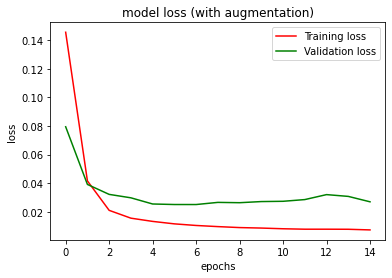

In [27]:
display_model_loss(15, results_aug, "model loss (with augmentation)")    

### 6.2 Display model accuracy loss

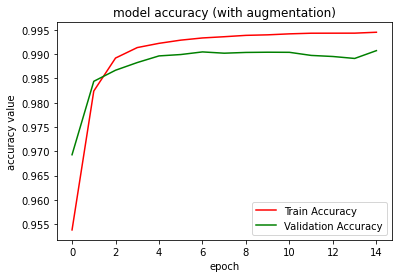

In [29]:
display_model_accuracy(15,results_aug,"model accuracy (with augmentation)")   

### 6.3 Display IoU metrics loss

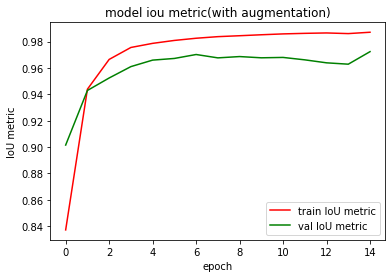

In [30]:
display_model_iou(15,results_aug,"model iou metric(with augmentation)")

In [31]:
aug_model = get_model_weights(model_weights_aug)
preds_val_aug, preds_test_aug = do_predictions(train_imgs_aug,val_imgs,aug_model, test_imgs)

7/7 [==============================] - 3s 469ms/step


### 6.4 Evaluate the model on testing dataset

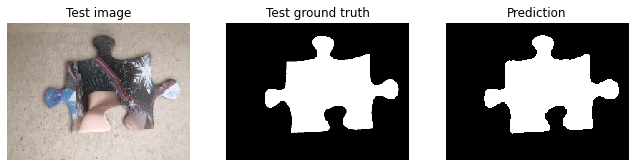

IoU value: 0.97


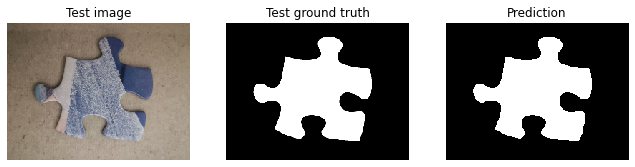

IoU value: 0.99


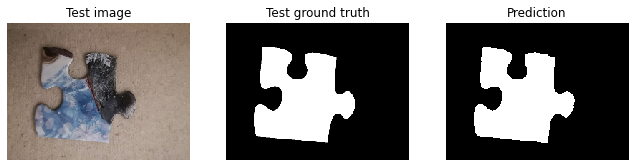

IoU value: 0.97


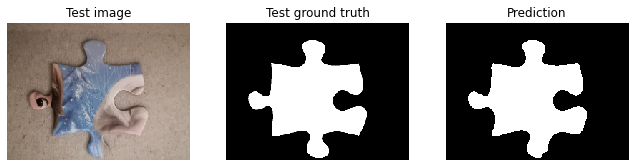

IoU value: 0.96


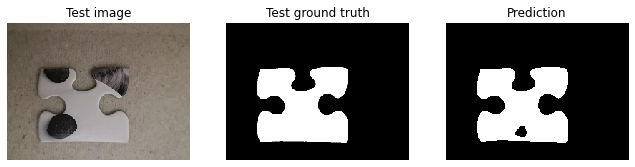

IoU value: 0.95


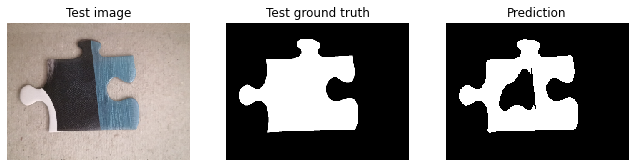

IoU value: 0.83


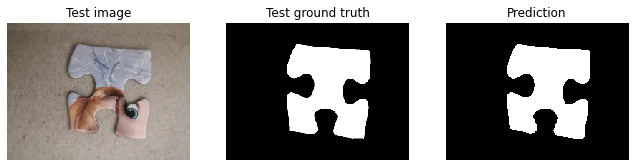

IoU value: 0.97


In [32]:
#display predictions
display_prediction(test_images,test_masks,preds_test_aug)

### 6.5 Compute Intersection over Union(IoU

In [33]:
iou = compute_iou(test_msks,preds_test_aug)         
print("Testing data averaged IoU ", iou)

Testing data averaged IoU  0.95


## 7. K-Fold Cross Validation

### 7.1 Prepare the dataset for 6 fold cross -validation

In [34]:
#===============concatention =========================

# merge input and predictions(without augmentation)
inputs = np.concatenate((train_val_imgs,test_imgs), axis=0)
targets = np.concatenate((train_val_msks, test_msks), axis=0)
print(len(inputs))
print(len(targets))

# merge input and predictions(with augmentation)
train_val_imgs_aug, train_val_msks_aug = data_augmentation(train_val_imgs, train_val_msks)


inputs_aug = np.concatenate((train_val_imgs_aug, test_imgs), axis=0)
targets_aug = np.concatenate((train_val_msks_aug, test_msks), axis=0)
print(len(inputs_aug))
print(len(targets_aug))

48
48
89
89


In [42]:
def kf_cross_validation(images, masks, model, num_folds, num_epochs,batch_size, checkpoint):
    
    acc_per_fold = []
    loss_per_fold = []

    kfold = KFold(n_splits=num_folds, shuffle=True)
    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1
    for train, test in kfold.split(images, masks):
        print("Fold no :", fold_no)
        history = model.fit(inputs_aug[train], targets_aug[train], 
            batch_size=batch_size, 
            epochs=num_epochs, 
            verbose=1, 
            shuffle=True, 
            validation_split=0.15,
            callbacks=checkpoint)

        scores = model.evaluate(inputs_aug[test], targets_aug[test], verbose=0)
        print(f'Fold no score {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(round(scores[1] * 100,3))
        loss_per_fold.append(round(scores[0],3))
        fold_no = fold_no + 1
    
    return history, acc_per_fold, loss_per_fold

### 7.2 Fit U-Net Without Augmentation (6-fold cross validation)

In [36]:
num_folds = 6
batch_size = 2
num_epochs = 50
kfold_model_checkpoint = model_checkpoints(kf_model_weights)
kfold_aug_model_checkpoint = model_checkpoints(kf_model_weights_aug)

kf_aug_callback_list = [early_stopping, kfold_aug_model_checkpoint]
kf_callback_list = [early_stopping,kfold_model_checkpoint]

In [38]:
k_time = time.time()
kfold_history, accuracy_per_fold, loss_per_fold = kf_cross_validation(inputs, targets,
                                                                      unet_aug,
                                                                      num_folds,
                                                                      num_epochs,
                                                                      batch_size,
                                                                      kf_callback_list)
print("Elapsed Time",time.time() - k_time, "seconds")

Fold no : 1
Train on 34 samples, validate on 6 samples
Epoch 1/50
34/34 [==============================] - 43s 1s/step - loss: 0.0116 - acc: 0.9931 - iou_metric: 0.9815 - val_loss: 0.0414 - val_acc: 0.9855 - val_iou_metric: 0.9520

Epoch 00001: val_loss improved from inf to 0.04141, saving model to weights/kfold_model_best_checkpoint.h5
Epoch 2/50
34/34 [==============================] - 44s 1s/step - loss: 0.0110 - acc: 0.9932 - iou_metric: 0.9816 - val_loss: 0.0774 - val_acc: 0.9830 - val_iou_metric: 0.9404

Epoch 00002: val_loss did not improve from 0.04141
Epoch 3/50
34/34 [==============================] - 44s 1s/step - loss: 0.0098 - acc: 0.9937 - iou_metric: 0.9832 - val_loss: 0.0994 - val_acc: 0.9808 - val_iou_metric: 0.9316

Epoch 00003: val_loss did not improve from 0.04141
Epoch 4/50
34/34 [==============================] - 44s 1s/step - loss: 0.0093 - acc: 0.9939 - iou_metric: 0.9846 - val_loss: 0.0751 - val_acc: 0.9835 - val_iou_metric: 0.9422

Epoch 00004: val_loss did no

### 7.3 Accuracy per fold

In [39]:
print("Accuracy per fold :",accuracy_per_fold)

Accuracy per fold : [99.341, 98.809, 99.551, 99.324, 99.573, 99.564]


### 7.4 Loss per fold

In [40]:
print("Loss per fold :", loss_per_fold)

Loss per fold : [0.013, 0.073, 0.005, 0.02, 0.004, 0.004]


## 8. Fit U-Net Without Augmentation (6-fold cross validation)

In [41]:
kf_aug_callback_list = [early_stopping, kfold_aug_model_checkpoint]

In [43]:
k_aug_time =time.time()
kfold_history_aug, accuracy_per_fold_aug, loss_per_fold_aug = kf_cross_validation(inputs_aug,
                                                                                  targets_aug,
                                                                                  unet_aug,
                                                                                  num_folds,
                                                                                  num_epochs,
                                                                                  batch_size,
                                                                                  kf_aug_callback_list)
print("Elapsed Time",time.time() - k_aug_time, "seconds")

Fold no : 1
Train on 62 samples, validate on 12 samples
Epoch 1/50
62/62 [==============================] - 79s 1s/step - loss: 0.9578 - acc: 0.7328 - iou_metric: 0.3071 - val_loss: 0.4790 - val_acc: 0.7498 - val_iou_metric: 0.0029

Epoch 00001: val_loss improved from inf to 0.47900, saving model to weights/kfold_aug_model_best_checkpoint.h5
Epoch 2/50
62/62 [==============================] - 80s 1s/step - loss: 0.3777 - acc: 0.8113 - iou_metric: 0.3111 - val_loss: 0.2811 - val_acc: 0.9029 - val_iou_metric: 0.6585

Epoch 00002: val_loss improved from 0.47900 to 0.28114, saving model to weights/kfold_aug_model_best_checkpoint.h5
Epoch 3/50
62/62 [==============================] - 80s 1s/step - loss: 0.1796 - acc: 0.9267 - iou_metric: 0.7382 - val_loss: 0.1439 - val_acc: 0.9399 - val_iou_metric: 0.8066

Epoch 00003: val_loss improved from 0.28114 to 0.14388, saving model to weights/kfold_aug_model_best_checkpoint.h5
Epoch 4/50
62/62 [==============================] - 80s 1s/step - loss: 

### 8.1 Accuracy per fold.

In [2]:
print("Accuracy per fold :", accuracy_per_fold_aug)

NameError: name 'accuracy_per_fold_aug' is not defined

### 8.2 Loss per fold

In [3]:
print("Loss per fold :", loss_per_fold_aug)

NameError: name 'loss_per_fold_aug' is not defined